# ELG redshift fitting analysis

In [1]:
import numpy as np
import healpy as hp
import fitsio
import astropy.table
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib import rcParams
import h5py
%pylab inline

# DESI modules
import desispec.io
from desisim.spec_qa import redshifts as dsq_z
from desisim.spec_qa import utils as dsq_u
from desitarget.targetmask import desi_mask

Populating the interactive namespace from numpy and matplotlib


In [2]:
froot = '/project/projectdirs/desi/datachallenge/reference_runs/19.2/'
f_truth = froot + 'targets/truth.fits'
f_zcata = froot + 'spectro/redux/mini/zcatalog-mini.fits'

---

#### Prepare data

In [3]:
# truth
truth_all = Table.read(f_truth, 'TRUTH')
truth_elg = Table.read(f_truth, 'TRUTH_ELG')

# redrock z catalog
zcat = Table.read(f_zcata)

truth_all['TRUESPECTYPE'] = np.char.strip(truth_all['TRUESPECTYPE'])
truth_all['TEMPLATETYPE'] = np.char.strip(truth_all['TEMPLATETYPE'])
zcat['SPECTYPE'] = np.char.strip(zcat['SPECTYPE'])

del truth_all.meta['EXTNAME']
del truth_elg.meta['EXTNAME']
del zcat.meta['EXTNAME']

# print('all sim targets: {:d}, all redrock targets: {:d}'.format(len(truth_all), len(zcat)))

In [4]:
# check if target ids are unique, as they should be
(len(np.unique(truth_all['TARGETID'])) == len(truth_all['TARGETID'])) & \
(len(np.unique(truth_elg['TARGETID'])) == len(truth_elg['TARGETID'])) & \
(len(np.unique(zcat['TARGETID'])) == len(zcat['TARGETID']))

True

In [5]:
# merge truth_all and truth_elg into truth
truth = astropy.table.join(truth_all, truth_elg, join_type='left', keys='TARGETID')

print(truth.colnames)

['TARGETID', 'MOCKID', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', 'TEMPLATESUBTYPE', 'TEMPLATEID', 'SEED', 'MAG', 'MAGFILTER', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'OIIFLUX', 'HBETAFLUX', 'EWOII', 'EWHBETA', 'D4000', 'VDISP', 'OIIDOUBLET', 'OIIIHBETA', 'OIIHBETA', 'NIIHBETA', 'SIIHBETA', 'TRUEZ_NORSD']


In [6]:
# check common keys in truth and zcat
print(np.intersect1d(truth.colnames, zcat.colnames))

['FLUX_G' 'FLUX_R' 'FLUX_W1' 'FLUX_W2' 'FLUX_Z' 'TARGETID']


In [7]:
# merge truth and zcat into ztruth

# all fitted targets with all info
# ztruth = astropy.table.join(truth, zcat, join_type='inner', keys='TARGETID')

# append masked columns [Z, ZERR, ZWARN, SPECTYPE, DESI_TARGET]
ztruth = truth.copy()
assigned = (zcat['TARGETID'] >= 0)
dsq_z.match_truth_z(ztruth, zcat[assigned], mini_read=True)

In [8]:
ztruth

TARGETID,MOCKID,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,MAGFILTER,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,EWOII,EWHBETA,D4000,VDISP,OIIDOUBLET,OIIIHBETA,OIIHBETA,NIIHBETA,SIIHBETA,TRUEZ_NORSD,Z,ZERR,ZWARN,SPECTYPE,DESI_TARGET
int64,int64,float32,str10,str10,str10,int32,int64,float32,str15,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,int64,str6,int64
288230398217945088,54992492,0.149173,GALAXY,BGS,,7628,993045393,20.0124,sdss2010-r,4.05495,11.0304,21.6917,28.1121,21.3384,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
288230398217945089,50735857,0.0629018,GALAXY,BGS,,344,236582212,19.8257,sdss2010-r,7.49606,12.3196,16.8876,10.6896,6.8277,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
288230398217945090,44193104,0.102394,GALAXY,BGS,,5376,266394818,18.8381,sdss2010-r,17.3049,30.7398,44.0025,30.4031,21.1332,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
288230398217945091,50325618,0.404096,GALAXY,BGS,,5318,465634076,19.7527,sdss2010-r,3.32961,14.4021,33.0712,70.3025,55.0462,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
288230398217945092,48652681,0.201318,GALAXY,BGS,,6316,1715747948,19.1592,sdss2010-r,7.47718,24.6473,54.3794,78.8524,58.958,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
288230398217945093,54061655,0.246611,GALAXY,BGS,,849,111129886,19.018,sdss2010-r,8.51624,27.5275,52.7909,59.4982,44.608,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
288230398217945094,51404195,0.208453,GALAXY,BGS,,3191,1149685579,19.2008,sdss2010-r,7.94728,23.1477,43.4831,45.7753,33.2121,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
288230398217945095,50831694,0.211673,GALAXY,BGS,,3280,180935224,19.1739,sdss2010-r,10.9217,22.8606,34.813,29.4197,21.8752,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
288230398217945096,54992450,0.145801,GALAXY,BGS,,5451,704391528,18.3514,sdss2010-r,19.8447,50.3027,91.0595,92.6586,64.8508,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--


---

#### Simple plot of True z vs Redrock z for `TEMPLATETYPE` ELGs

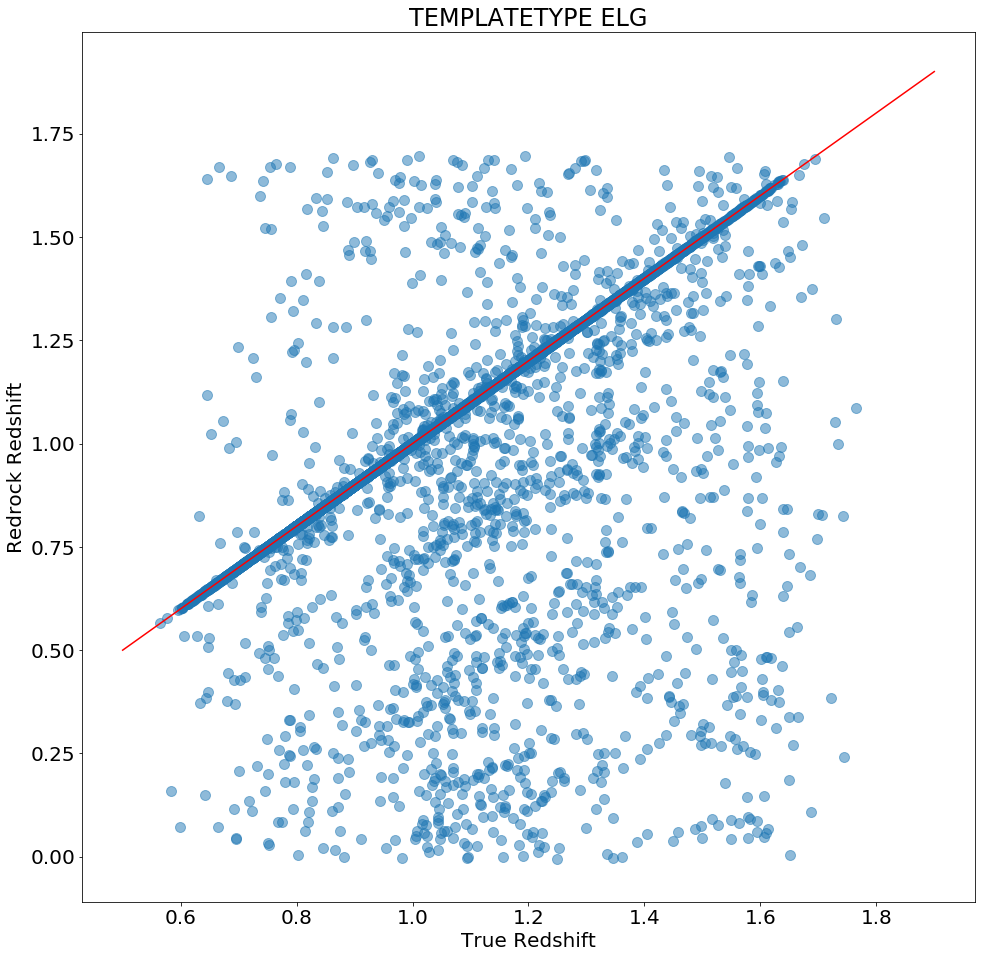

In [9]:
rcParams['figure.figsize'] = [16, 16]
rcParams['font.size'] = 20
fig, (ax) = plt.subplots(1, 1)
# y = x line
ax.plot([0.5, 1.9], [0.5, 1.9], 'r-')

idx = (ztruth['TEMPLATETYPE'] == 'ELG')
ax.scatter(ztruth[idx]['TRUEZ'], ztruth[idx]['Z'], s=100, alpha=0.5)

# ax.set_xlim(0.5, 1.9)
ax.set_xlabel('True Redshift')

# ax.set_ylim(0.5, 1.9)
ax.set_ylabel('Redrock Redshift')

ax.set_title('TEMPLATETYPE ELG')

plt.show()

---

#### Some statistics

In [10]:
# true ELGs classified as 'GALAXY' by Redrock?
sel_elg = (ztruth['TEMPLATETYPE'] == 'ELG')
print('# simulated ELGs: {:d}'.format(np.count_nonzero(sel_elg)))
sel_elg = sel_elg & (~ztruth['Z'].mask)
n_sel = np.count_nonzero(sel_elg)
print('# selected ELGs: {:d}'.format(n_sel))
print('Redrock types: ', set(ztruth[sel_elg]['SPECTYPE']))
print('Galaxy: ', np.count_nonzero(ztruth[sel_elg]['SPECTYPE']=='GALAXY'), '/', n_sel)
print('Others: ', np.count_nonzero(ztruth[sel_elg]['SPECTYPE']!='GALAXY'), '/', n_sel)

# simulated ELGs: 82769
# selected ELGs: 15585
Redrock types:  {'GALAXY', 'QSO'}
Galaxy:  15583 / 15585
Others:  2 / 15585


In [11]:
# different masks
# good, fail, miss or lost?
objtype_mask, z_mask, survey_mask, dv_mask, zwarn_mask = dsq_z.criteria(ztruth, objtype='ELG')
good_mask = zwarn_mask & dv_mask & objtype_mask & z_mask
fail_mask = zwarn_mask & (~dv_mask) & objtype_mask & z_mask
miss_mask = (~zwarn_mask) & dv_mask & objtype_mask & z_mask
lost_mask = (~zwarn_mask) & (~dv_mask) & objtype_mask & z_mask
tot_mask = objtype_mask & z_mask

ntot = np.count_nonzero(tot_mask)

ngood = np.count_nonzero(good_mask)
nfail = np.count_nonzero(fail_mask)
nmiss = np.count_nonzero(miss_mask)
nlost = np.count_nonzero(lost_mask)

pgood = ngood * 100 / ntot
pfail = nfail * 100 / ntot
pmiss = nmiss * 100 / ntot
plost = nlost * 100 / ntot

print('     ELG     ntarg    good   fail   miss   lost')
print('{:>8s}  {:8d}   {:5d}  {:5d}  {:5d}  {:5d}'.format('number', ntot, ngood, nfail, nmiss, nlost))
print('{:>8s}  {:8.1f}   {:5.1f}  {:5.1f}  {:5.1f}  {:5.1f}'.format('percent', 100.0, pgood, pfail, pmiss, plost))

     ELG     ntarg    good   fail   miss   lost
  number     17204   13918    108   1415   1763
 percent     100.0    80.9    0.6    8.2   10.2


In [12]:
# confusion matrix
specmix = dsq_z.spectype_confusion(ztruth)
specmix

{'GALAXY': {'GALAXY': 35322, 'QSO': 3, 'STAR': 1},
 'QSO': {'QSO': 3089, 'GALAXY': 21, 'STAR': 0},
 'STAR': {'STAR': 3159, 'GALAXY': 377, 'QSO': 0},
 'WD': {'WD': 0, 'GALAXY': 0, 'QSO': 0, 'STAR': 97}}

In [13]:
specmix['GALAXY']['WD'] = 0
specmix['QSO']['WD'] = 0
specmix['STAR']['WD'] = 0
spectypes = ['GALAXY', 'QSO', 'STAR', 'WD']

print('            Redrock')
print('Truth     ', end='')
for s1 in spectypes:
    print('{:>8s}'.format(s1), end='')
print()
    
for s1 in spectypes:
    print('{:8s}  '.format(s1), end='')
    for s2 in spectypes:
        print('{:8d}'.format(specmix[s1][s2]), end='')
    print()

            Redrock
Truth       GALAXY     QSO    STAR      WD
GALAXY       35322       3       1       0
QSO             21    3089       0       0
STAR           377       0    3159       0
WD               0       0      97       0


- Q: relation between `SPECTYPE` and `DESI_TARGET`?

---

#### Compare `DESI_TARGET` ELGs with `TEMPLATETYPE` ELGs

In [14]:
rr_elg_mask = objtype_mask & z_mask
print('number of Redrock ELGs: ', np.count_nonzero(rr_elg_mask))

number of Redrock ELGs:  17204


In [15]:
tt_elg_mask = (ztruth['TEMPLATETYPE'] == 'ELG') & z_mask
print('number of template ELGs: ', np.count_nonzero(tt_elg_mask))

number of template ELGs:  15585


In [16]:
rr_elg_id = ztruth[rr_elg_mask]['TARGETID']

In [17]:
tt_elg_id = ztruth[tt_elg_mask]['TARGETID']

In [18]:
# check if all template ELGs are redrock ELGs
np.count_nonzero(np.isin(tt_elg_id, rr_elg_id)) == np.count_nonzero(tt_elg_mask)

True

In [19]:
# look at template type of the rest redrock ELGs
res_mask = ~np.isin(rr_elg_id, tt_elg_id)
res_type = ztruth[rr_elg_mask][res_mask]['TEMPLATETYPE']
for tt in set(res_type):
    print(tt, ' : ', np.count_nonzero(res_type == tt))

STAR  :  43
BGS  :  1576


In [20]:
res_mask_bgs = (ztruth[rr_elg_mask]['TEMPLATETYPE'] == 'BGS')
res_mask_star = (ztruth[rr_elg_mask]['TEMPLATETYPE'] == 'STAR')

# check length
print(len(ztruth[rr_elg_mask][res_mask_bgs]), len(ztruth[rr_elg_mask][res_mask_star]))

1576 43


- It seems that all `TEMPLATETYPE` ELGs are `DESI_TARGET` ELGs, while some BGS's and STARs are also `DESI_TARGET` ELGs.

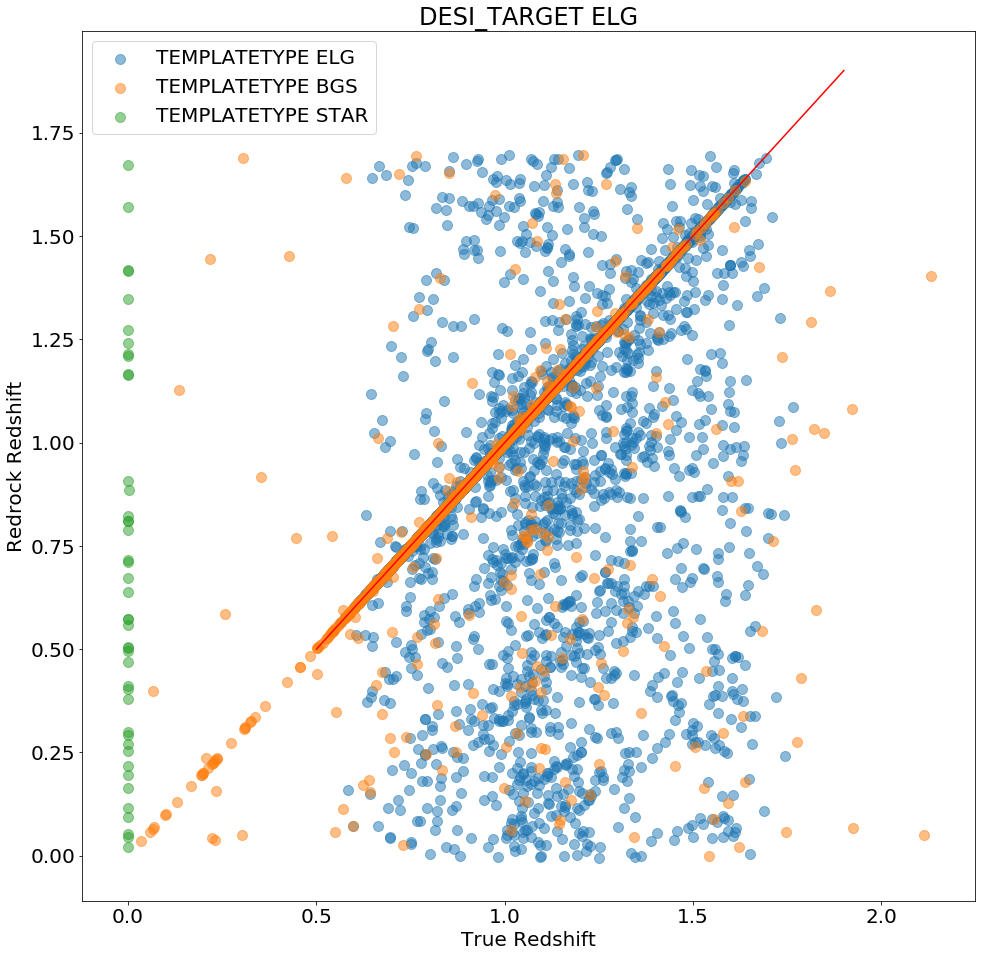

In [21]:
rcParams['figure.figsize'] = [16, 16]
rcParams['font.size'] = 20
fig, (ax) = plt.subplots(1, 1)
# y = x line
ax.plot([0.5, 1.9], [0.5, 1.9], 'r-')

ax.scatter(ztruth[tt_elg_mask]['TRUEZ'], ztruth[tt_elg_mask]['Z'], c='tab:blue', s=100, alpha=0.5, label='TEMPLATETYPE ELG')
ax.scatter(ztruth[rr_elg_mask][res_mask_bgs]['TRUEZ'], ztruth[rr_elg_mask][res_mask_bgs]['Z'],
           c='tab:orange', s=100, alpha=0.5, label='TEMPLATETYPE BGS')
ax.scatter(ztruth[rr_elg_mask][res_mask_star]['TRUEZ'], ztruth[rr_elg_mask][res_mask_star]['Z'],
           c='tab:green', s=100, alpha=0.5, label='TEMPLATETYPE STAR')

# ax.set_xlim(0.5, 1.9)
ax.set_xlabel('True Redshift')

# ax.set_ylim(0.5, 1.9)
ax.set_ylabel('Redrock Redshift')

ax.set_title('DESI_TARGET ELG')
ax.legend()

plt.show()

---


#### Plot `DESI_TARGET` ELGs with good, fail, miss and lost

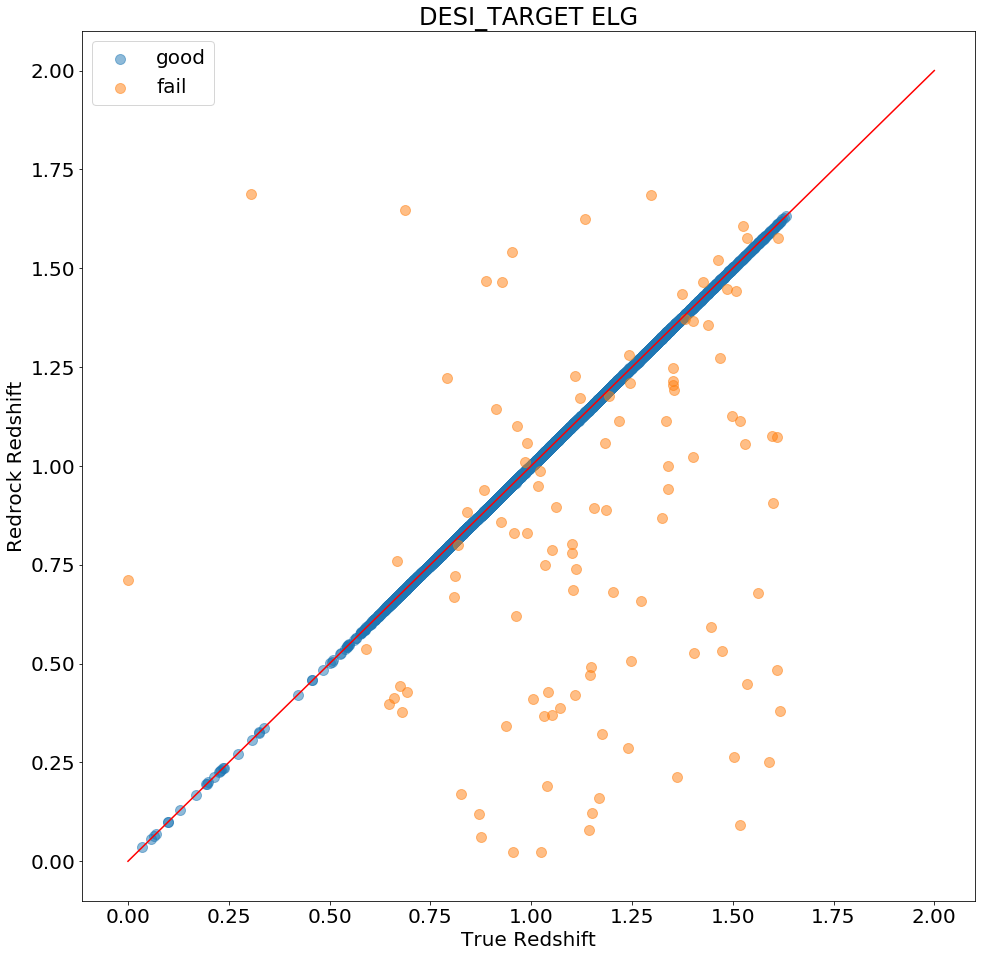

In [22]:
rcParams['figure.figsize'] = [16, 16]
rcParams['font.size'] = 20
fig, (ax) = plt.subplots(1, 1)
# y = x line
ax.plot([0, 2], [0, 2], 'r-')

ax.scatter(ztruth[good_mask]['TRUEZ'], ztruth[good_mask]['Z'], c='tab:blue', s=100, alpha=0.5, label='good')
ax.scatter(ztruth[fail_mask]['TRUEZ'], ztruth[fail_mask]['Z'], c='tab:orange', s=100, alpha=0.5, label='fail')
# ax.scatter(ztruth[miss_mask]['TRUEZ'], ztruth[miss_mask]['Z'], c='tab:green', s=100, alpha=0.5, label='miss')
# ax.scatter(ztruth[lost_mask]['TRUEZ'], ztruth[lost_mask]['Z'], c='tab:gray', s=100, alpha=0.5, label='lost')

# ax.set_xlim(0, 2)
ax.set_xlabel('True Redshift')

# ax.set_ylim(0, 2)
ax.set_ylabel('Redrock Redshift')

ax.set_title('DESI_TARGET ELG')
ax.legend()

plt.show()

---

## Look into good and fail ELGs

In [23]:
# template type
print('fail:')
for tt in set(ztruth[fail_mask]['TEMPLATETYPE']):
    print(tt, ':', np.count_nonzero(ztruth[fail_mask]['TEMPLATETYPE']==tt))
    
print('good:')
for tt in set(ztruth[good_mask]['TEMPLATETYPE']):
    print(tt, ':', np.count_nonzero(ztruth[good_mask]['TEMPLATETYPE']==tt))

fail:
STAR : 1
BGS : 17
ELG : 90
good:
BGS : 1189
ELG : 12729


In [24]:
fail_tt_masks = {}
good_tt_masks = {}
for tt in set(ztruth[fail_mask]['TEMPLATETYPE']):
    fail_tt_masks[tt] = ztruth[fail_mask]['TEMPLATETYPE']==tt

for tt in set(ztruth[good_mask]['TEMPLATETYPE']):
    good_tt_masks[tt] = ztruth[good_mask]['TEMPLATETYPE']==tt

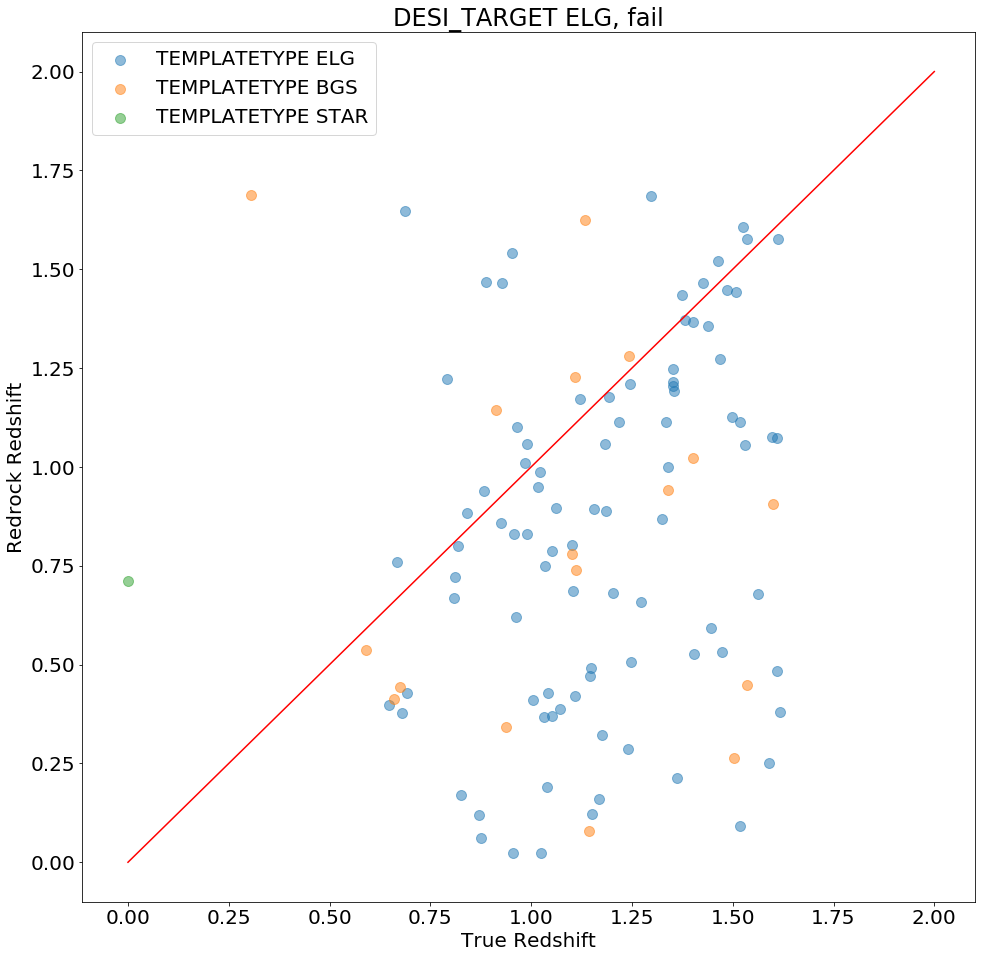

In [25]:
rcParams['figure.figsize'] = [16, 16]
rcParams['font.size'] = 20
fig, (ax) = plt.subplots(1, 1)
# y = x line
ax.plot([0, 2], [0, 2], 'r-')

ax.scatter(ztruth[fail_mask][fail_tt_masks['ELG']]['TRUEZ'], ztruth[fail_mask][fail_tt_masks['ELG']]['Z'], 
           c='tab:blue', s=100, alpha=0.5, label='TEMPLATETYPE ELG')
ax.scatter(ztruth[fail_mask][fail_tt_masks['BGS']]['TRUEZ'], ztruth[fail_mask][fail_tt_masks['BGS']]['Z'], 
           c='tab:orange', s=100, alpha=0.5, label='TEMPLATETYPE BGS')
ax.scatter(ztruth[fail_mask][fail_tt_masks['STAR']]['TRUEZ'], ztruth[fail_mask][fail_tt_masks['STAR']]['Z'], 
           c='tab:green', s=100, alpha=0.5, label='TEMPLATETYPE STAR')


# ax.set_xlim(0, 2)
ax.set_xlabel('True Redshift')

# ax.set_ylim(0, 2)
ax.set_ylabel('Redrock Redshift')

ax.set_title('DESI_TARGET ELG, fail')
ax.legend()

plt.show()

#### Pick out the targets for convenience

In [26]:
# TEMPLATETYPE==ELG & DESI_TARGET==ELG
ztruth_elg_fail = ztruth[fail_mask][fail_tt_masks['ELG']]
ztruth_elg_good = ztruth[good_mask][good_tt_masks['ELG']]

# get the pixel number to locate spectra
zcat_pix = zcat['TARGETID', 'HPXPIXEL']
ztruth_elg_fail = astropy.table.join(ztruth_elg_fail, zcat_pix, join_type='inner', keys='TARGETID')
ztruth_elg_good = astropy.table.join(ztruth_elg_good, zcat_pix, join_type='inner', keys='TARGETID')

### One target

In [64]:
# pick out one of the targets
# elg_pick = ztruth_elg_fail[0]
elg_pick = ztruth_elg_good[0]
tid = elg_pick['TARGETID']
ipix = elg_pick['HPXPIXEL']

spec_path = 'spectro/redux/mini/spectra-64/{:d}/{:d}/'.format(ipix//100, ipix)

print(ipix, spec_path)

5262 spectro/redux/mini/spectra-64/52/5262/


#### Goodness of fitting $\chi^2$

In [65]:
# redrock-64-{pix}.h5 file
fh5 = h5py.File(froot + spec_path + 'redrock-64-{:d}.h5'.format(ipix))
list(fh5.keys())

idx = (np.array(fh5['targetids']) == tid)

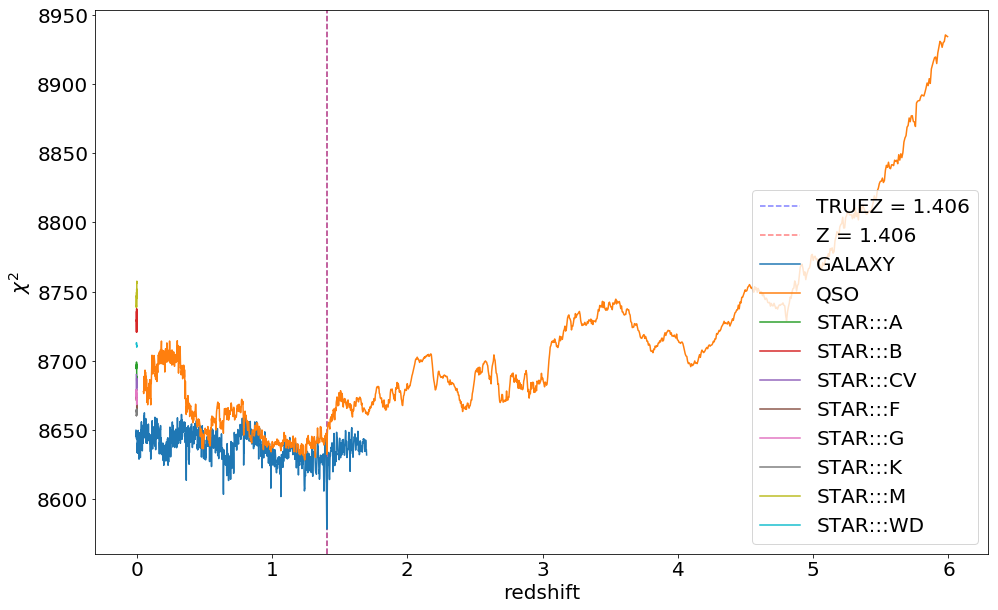

In [66]:
# plot all chi2
rcParams['figure.figsize'] = [16, 10]
rcParams['font.size'] = 20
fig, (ax) = plt.subplots(1, 1)

ax.axvline(elg_pick['TRUEZ'], c='b', ls='--', alpha=0.5, label='TRUEZ = {:.3f}'.format(elg_pick['TRUEZ']))
ax.axvline(elg_pick['Z'], c='r', ls='--', alpha=0.5, label='Z = {:.3f}'.format(elg_pick['Z']))

templates = list(fh5['zscan'])
for tt in templates:
#     if tt != 'GALAXY': continue
    redshifts = fh5['zscan'][tt]['redshifts']
    zchi2 = fh5['zscan'][tt]['zchi2'][idx, :][0]
    ax.plot(redshifts, zchi2, label=tt)

ax.set_xlabel('redshift')
ax.set_ylabel('$\chi^2$')

ax.legend()
plt.show()

#### Spectrum

In [67]:
# spectra-64-{pix}.fits file
specobj = desispec.io.read_spectra(froot + spec_path + 'spectra-64-{:d}.fits'.format(ipix))

In [68]:
# specobj for one target
specot = specobj.select(targets=[tid])
# just make sure
assert specot.target_ids()[0]==tid

print('target id: ', specot.target_ids()[0])
print('number of spectra: ', specot.num_spectra())

target id:  288230398222141997
number of spectra:  2


In [69]:
bwave = specot.wave['b']
rwave = specot.wave['r']
zwave = specot.wave['z']

In [70]:
bflux = specot.flux['b']
rflux = specot.flux['r']
zflux = specot.flux['z']

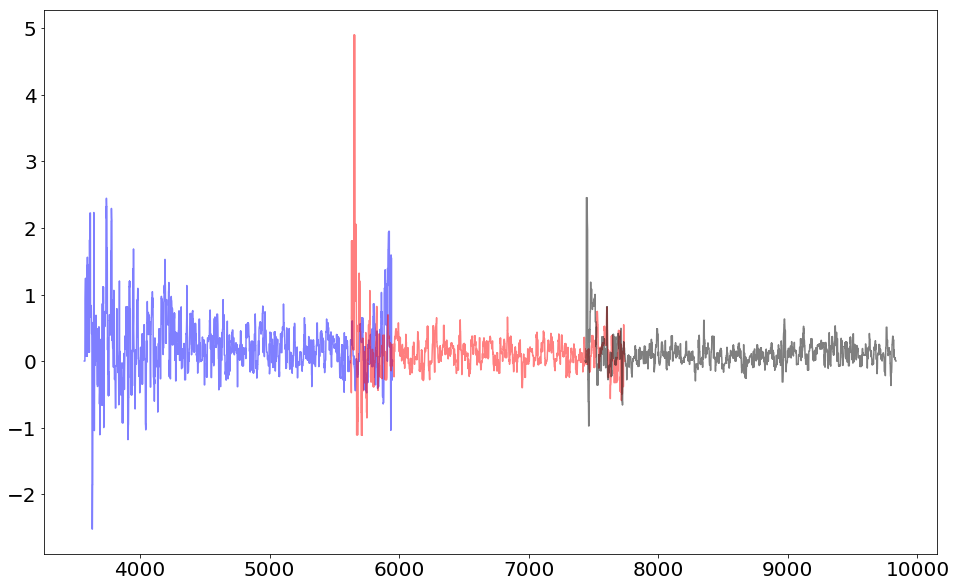

In [78]:
from scipy.signal import medfilt

# plot the spectrum
rcParams['figure.figsize'] = [16, 10]
rcParams['font.size'] = 20
fig, (ax) = plt.subplots(1, 1)

ss = 0
ks = 15 # kernel_size

ax.plot(bwave, medfilt(bflux[ss], ks), 'b', alpha=0.5)
ax.plot(rwave, medfilt(rflux[ss], ks), 'r', alpha=0.5)
ax.plot(zwave, medfilt(zflux[ss], ks), 'k', alpha=0.5)

plt.show()